# Fall 2025 - Assignment 2

* Geoffroy Hébert-Emond - 11273505
* Loubna Naciri - 1

Electronic submission on ZoneCours no later than **December 5 at 11:55 PM** of:

* This Jupyter notebook (.ipynb) as the report, after adding your answers.
* All .py files necessary to run the notebook

The report must:

* be in .ipynb format (points will be deducted for any other format).
* answer the questions and discuss the results using tables, figures, and Markdown cells.

Grading rubric:

* **40%** Accuracy of results
* **25%** Complete and concise discussions (Markdown cells)
* **20%** Conciseness of the notebook (.ipynb with minimal code) and clarity of figures
* **15%** Code clarity (.py)

# Option Valuation with Dynamic Volatility

The objective of this assignment is to compute a synthetic, model-based counterpart to the VIX using some of the models seen in class.

In [9]:
# The following import allow absolute imports scripts within the dorion_francois package
#import internal_script 

import datetime as dt
import os
import sys
import numpy as np
import pandas as pd
import pickle
import importlib
from scipy.stats import gaussian_kde

from scipy import stats
from scipy.optimize import minimize
import matplotlib.pyplot as plt


# Question 1

Using the data provided in `spx.csv`, estimate the parameters of Duan's (1995) nonaffine GARCH model (NGARCH) as described in the note. In particular, work under the assumption that innovations are $N(0,1)$. Note that the index levels provided in the csv file are ex-dividend, so that log returns computed from those will also be ex-dividend returns, that is:
$$
\log\left(\frac{S_{t+1}}{S_t}\right)
= r_f - y + \lambda \sqrt{h_{t+1}} - \frac{1}{2}h_{t+1} + \sqrt{h_{t+1}}\varepsilon_{t+1}
$$
In order to estimate the risk-premium parameter driving the cum-dividend equity premium $e^{\lambda \sqrt{h_{t+1}}}$, you should thus consider cum-dividend log-excess returns $\tilde{r}_{t+1} = \log\left(\frac{S_{t+1}}{S_t}\right) + y - r_f$. 

Here is how to approximate $y$: for dates prior to 1996-01-04, use the annual dividend yield values published by [Aswath Damodaran](https://pages.stern.nyu.edu/~adamodar/New_Home_Page/datafile/spearn.htm?utm_source=chatgpt.com). Then, use the yields in `spx_divyields.csv` at the shortest nonzero horizon (e.g. on 2024-12-31, the yield with expiration on 2025-01-02). Remember that both sources provide annualized yields whereas the model requires a measure at the daily frequency.

Diagnose whether $\lbrace{ \varepsilon_t }\rbrace$ are indeed $N(0,1)$ by tabulating a Jarque-Bera (JB) test and an Anderson–Darling (AD) for uniformity of $\lbrace{ u_t }\rbrace = \lbrace{ \Phi(\varepsilon_t) }\rbrace$, where $\Phi$ is the CDF of the standard normal. Also discuss a qqplot of the $\lbrace{ \varepsilon_t }\rbrace$.

_______________________________
**Please note that we are using multiple points to start the optimization, in order to avoid getting stuck in a local minima. As such running question 1 can take 5+ minutes. **
____________

Estimated NGARCH(1,1) parameters (multi-start):
           lambda =  0.0414733
            omega =  1.47491e-06
            alpha =  0.0595023
             beta =  0.912369
            gamma =  0.239814
    sigma2_uncond =  5.96967e-05

Converged: True


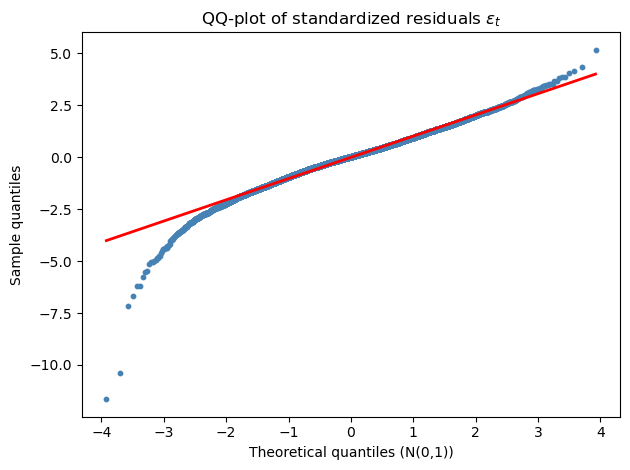

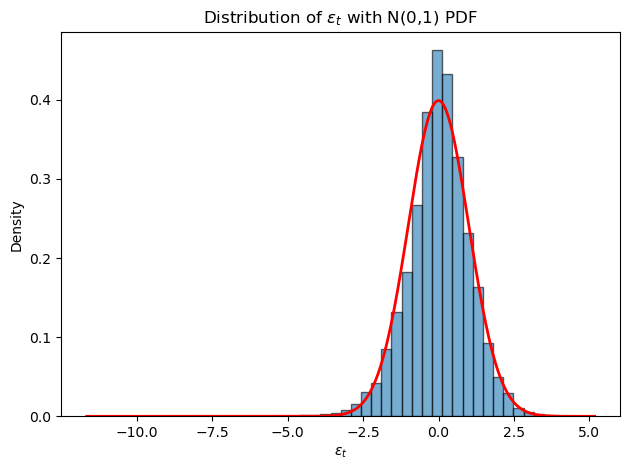

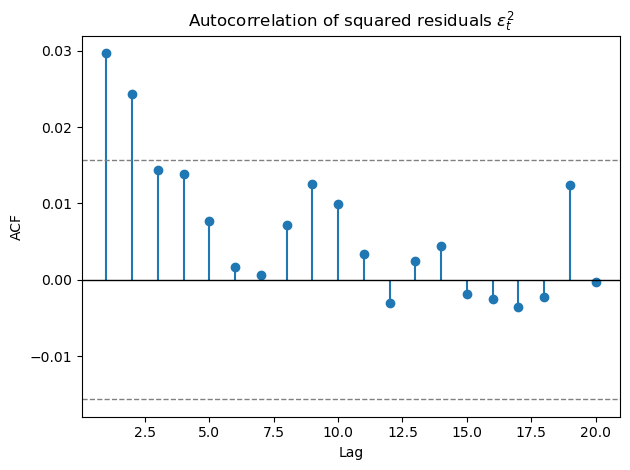

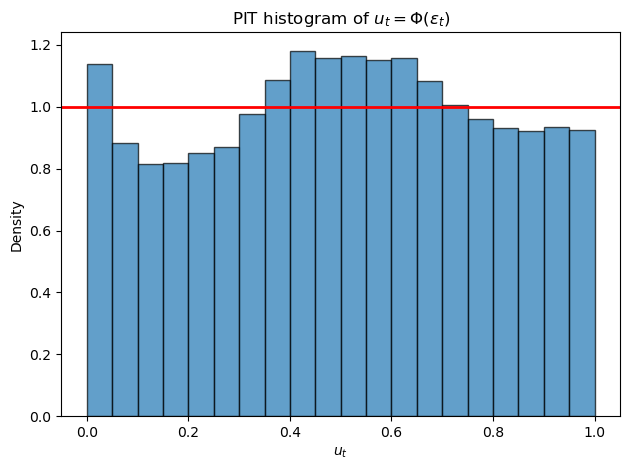


========== Residual diagnostics for epsilon t ==========

Jarque–Bera test for normality of ε_t:
  JB statistic      :  6842.9694
  p-value           :          0
  Skewness          :    -0.4827
  Pearson kurtosis  :     6.0849
  -> Reject normality of ε_t at the 5% level.

Anderson–Darling test for uniformity of u_t = Φ(ε_t):
  A^2 statistic     :    26.0556
  5% critical value :     2.4920  (large-sample)
  -> Reject uniformity of u_t at the 5% level.


In [2]:
###### Question 1 ######

from q1 import run_q1, estimate_ngarch_q1, plot_ngarch_diagnostics
spx, y_daily, rf_daily, r, h, eps, params, opt_res = run_q1()

_______________
Even after fitting a garch with the assumption N(0,1) innovations, the residuals have negative skew and high kurtosis, which suggest that they are left-skewed and heavy-tailed. As for the QQ-Plot, the NGARCH model captures the bulk of the distribution well but shows fat tails, espcially, the left tail which suggest that they are many more extreme negative residuals than a normal gaussian would predict. We can likely attribute this left tail to many crashes and market downturns in the past (Dotcom bubble, 2008 crisis, pandemic, etc..) 

The formal tests are giving us the same story The Jarque–Bera statistic is very large and the p-value is essentially zero, so we strongly reject the null hypothesis that $\varepsilon_t$ is gaussian. Furthermore, The Anderson–Darling test also rejects the null hypothesis of uniformity, which means that the transformed residuals do not behave as if they were truly standard normal across the full distribution.

Looking at the additional graphics, we can see that the histogram of $\varepsilon_t$ overlaid with the N(0,1) show more mass in the center and in the extreme left tail compared to the normal, which is in line with our other results. Then the ACF of squared residuals $\varepsilon_t^2$ is small but still shows some  autocorrelation at short lags, suggesting that the NGARCH does not capture all the volatility clustering in the data. Finally, the graph for the PIT has a hump in the middle and thinner tails which shows that the gaussian assumptions of innovations is not adequate. 
_______________


# Question 2

Download the VIX data from the [Cboe website](https://cdn.cboe.com/api/global/us_indices/daily_prices/VIX_History.csv). Between Jan 1990 and Dec 2024, plot the VIX alongside $100\times$ the annualized volatilty as filtered under the Duan model. 

Describe the similarity and differences between the two series. Don't hesitate to support your analysis with statistics and statistical tests.

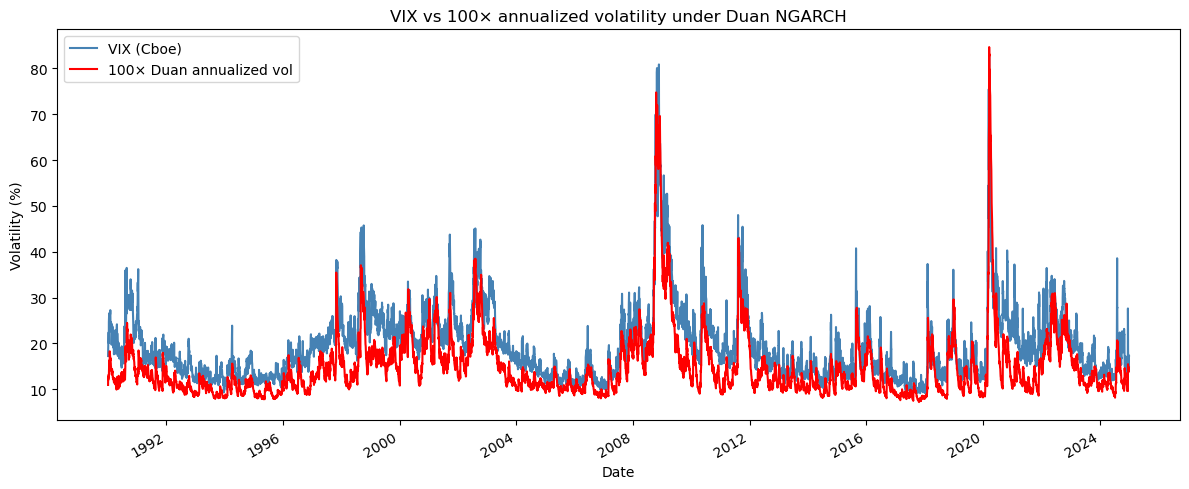

Summary statistics (Jan 1990 – Dec 2024):
               VIX  Duan_AnnVol_x100
count  8813.000000       8813.000000
mean     19.467929         14.809822
std       7.844702          7.439525
min       9.140000          7.190770
25%      13.830000         10.425471
50%      17.620000         12.686339
75%      22.820000         16.851389
max      82.690000         84.645268

Correlation matrix:
                       VIX  Duan_AnnVol_x100
VIX               1.000000          0.892769
Duan_AnnVol_x100  0.892769          1.000000


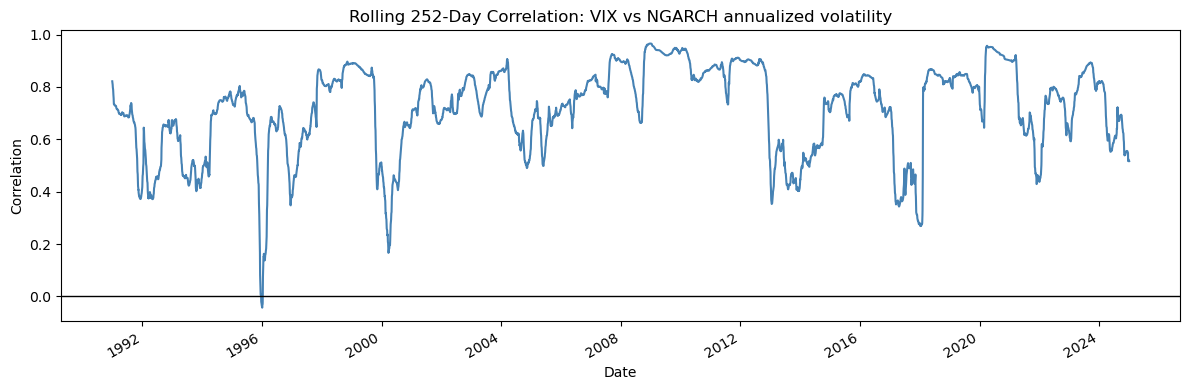

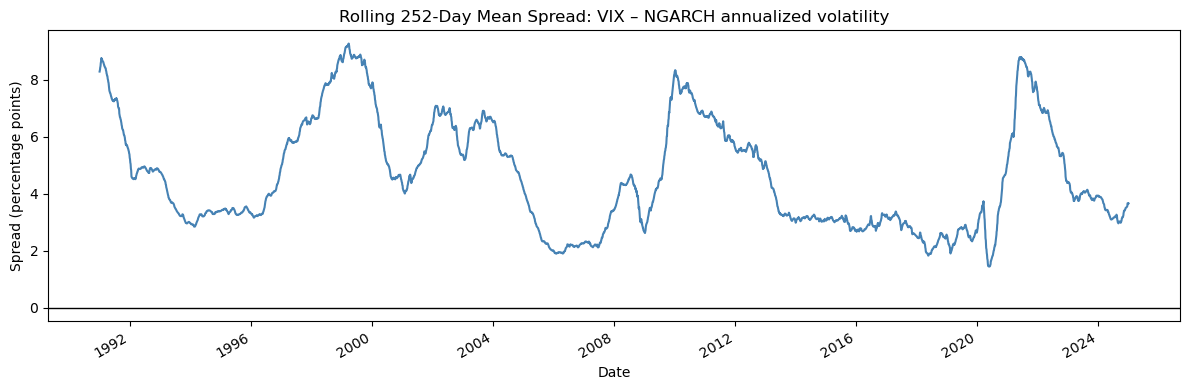


OLS regression: VIX_t = a + b * NGARCH_vol_t + error_t
--------------------------------------------------------
Number of observations: 8813
R-squared            : 0.7970

Coefficient estimates:
  alpha (intercept) :  5.5261  (SE =  0.0839,  t =  65.88)
  beta  (slope)     :  0.9414  (SE =  0.0051,  t =  186.01)

Jarque–Bera test on OLS residuals:
  JB statistic : 5294.1122
  p-value      : 0
  -> Reject normality of regression errors at 5% level.

Mean spread test: H0: E[VIX − NGARCH_vol] = 0
  Sample mean spread      : 4.6581 %-pts (465.81 bps)
  Standard error of mean  : 0.037932
  t-statistic             : 122.80
  p-value                 : 0
  -> Reject H0 at 5% level: positive mean spread,
     evidence of a statistically significant volatility risk premium.


In [6]:
####### Question 2 ######

from q2 import run_vix_duan_analysis, load_vix 
results = run_vix_duan_analysis(h, r, vix_path="VIX_History.csv")
df = results["df"]
spread_test = results["spread_test"]
ols_res = results["ols"]
vix_close = load_vix("VIX_History.csv") 

____________
Over the time frame, the NGARCH volatility under $P$ and the VIX under $Q$ move very closely together. Visually, both series will have the same spikes and the exact same time, and the correlation between both is very high. This means that the Duan NGARCH captures the main dynamics and volatility regimes of the S&P 500, as such, when the VIX jumps, the model-implied volatility under $P$ jumps as well.

However the level of volatility is quite different. The average VIX is about 19.5% versus the model which is at 14.8% so the model under $P$ is roughly 4.5 volatility points below the option-implied level on average.

We also used the 252-day rolling mean spread, which can be defined as: 

$
\text{Spread}_t = \text{VIX}_t - \text{Vol}^{\text{NGARCH}}_t 
$

The spread is is almost always positive and tends to widen sharply in crises. This shows (as expected) that the risk premium is counter cyclical and varies with time. The formal tests also confirms this. Indeed, the  mean spread is about $4.66$ percentage point and the $t$-test rejects the foloowing hypothesis: 

 $H_0 : \mathbb{E}\!\left[\text{VIX} - \text{Vol}^{\text{NGARCH}}\right] = 0$

With a  large $t$-statistic  and a $p$-value almost equal to zero. So VIX is statistically higher than NGARCH volatility, consistent with the positive risk premium in option prices.

We then decided to use the following OLS regression: 

$
\text{VIX}_t = \alpha + \beta\,\text{Vol}^{\text{NGARCH}}_t + \varepsilon_t
$

The regression gives us gives an intercept $\alpha \approx 5.5$ and slope $\beta \approx 0.94$ with $R^2 \approx 0.80$. So a one-for-one relationship in sensitivity is reasonable (since $\beta \approx 1$), but there is a positive and constant shift of about $5$–$6$ points: even when $\text{Vol}^{\text{NGARCH}}_t$ is “zero” in the regression, where the VIX would still sit around $5$–$6%$. The Jarque–Bera test on the regression residuals rejects normality, which is consistent with option-implied volatility reacting more strongly in extreme periods than a Gaussian NGARCH under $P$ can capture.

Finally, the rolling 252-day correlation is typically very high (often $0.7$–$0.9$) in “normal” times but drops during regime shifts and crises, indicating that when volatility reprices very abruptly, the risk-neutral VIX adjusts faster than the NGARCH model estimated on historical returns.

______________

# Question 3

(Ideally) On each of the 8834 days in the Jan90-Dec24 sample, evaluate the option prices of 1-month, OTM puts and calls with standardized moneyness 
$$
m = \frac{\log\frac{K}{F}}{\sqrt{(252/12) h_{t+1}}}
$$
ranging from -5 to +5. To do so, you first need to apply the LRNVR to obtain the risk-neutral parametrization of the model. Prior to 1996, you can still use Damodoran's dividend yields. From 1996, use the `spx_divyields.csv` yields interpolated at 30 calendar days. Simulate $N_S$ paths over 21-business days, with $N_S = 20,000$: For each day, draw $10,000$ shocks, use the $10,000$ antithetic variates and standardize the resulting shocks (across paths, not time) to avoid simulation noise around forward prices.

Apply the VIX methodology to these options prices and plot the "model-based" VIX alongside the model's physical volatility and the actual VIX. Discuss the similarities and differences, supporting your discussion with the necessary statistics. 

Hint: start by doing the analyzing using 1 day a week (ideally, Wednesdays), to make sure you are on the right track. That will go roughly 5 times faster than working on daily data. If your computer has multiple cores, days can be analyzed in parallel.

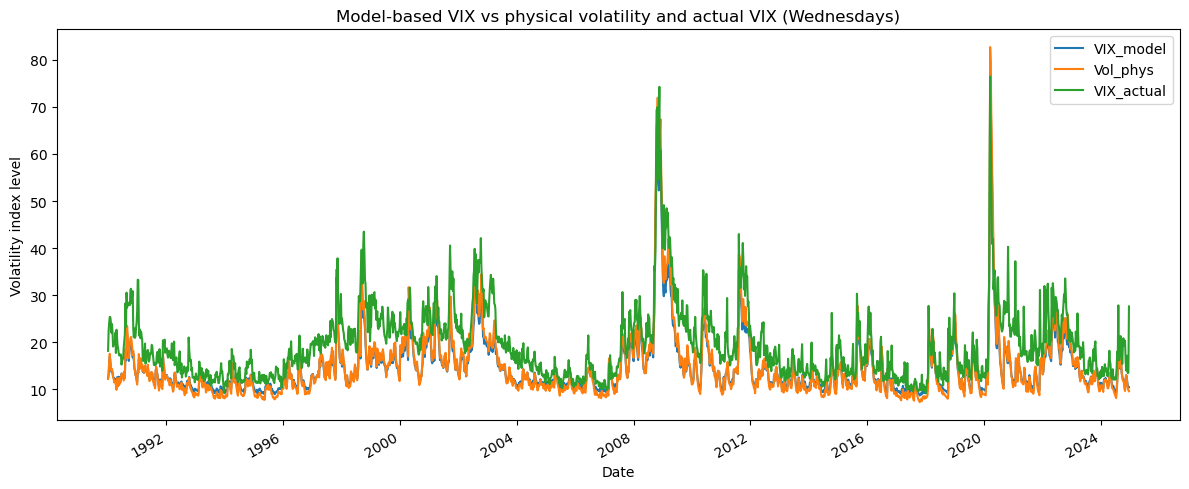

Q3 correlation matrix:
            VIX_model  Vol_phys  VIX_actual
VIX_model    1.000000  0.999366    0.892780
Vol_phys     0.999366  1.000000    0.897809
VIX_actual   0.892780  0.897809    1.000000

Q3 summary statistics:
         VIX_model     Vol_phys   VIX_actual
count  1805.000000  1805.000000  1805.000000
mean     14.725782    14.828427    19.443889
std       6.446575     7.472925     7.798583
min       8.700872     7.304338     9.150000
25%      11.010159    10.383944    13.790000
50%      12.779963    12.670446    17.770000
75%      16.316756    16.899353    22.690000
max      75.133398    82.701346    76.450000


In [ ]:
#  MODEL-BASED VIX 

# Prep series and risk-neutral parameters
h_series = pd.Series(h, index=r.index, name="h")
duan_vol_ann = np.sqrt(252.0 * h_series) * 100.0   # 100× physical NGARCH vol

def get_rn_params(params):
    """
    Risk-neutral NGARCH parameters:
      γ_Q = γ + λ, λ_Q = 0.
    """
    params_Q = params.copy()
    params_Q['gamma']  = params['gamma'] + params['lambda']
    params_Q['lambda'] = 0.0
    return params_Q

params_Q = get_rn_params(params)

# NGARCH simulation under Q
def simulate_ngarch_paths_Q(S0, h0, rf_d, y_d, params_Q,
                            n_days=21, n_paths=20000, random_state=None):

    rng = np.random.default_rng(random_state)
    omega = params_Q['omega']
    alpha = params_Q['alpha']
    beta  = params_Q['beta']
    gammaQ = params_Q['gamma']

    n_half = n_paths // 2
    n_paths = 2 * n_half  
    S = np.full(n_paths, S0, dtype=float)
    h = np.full(n_paths, h0, dtype=float)

    for _ in range(n_days):
        z_half = rng.standard_normal(n_half)
        eps = np.concatenate([z_half, -z_half])
        eps = (eps - eps.mean()) / eps.std(ddof=1)
        r_excess = -0.5 * h + np.sqrt(h) * eps
        log_ret = r_excess - y_d + rf_d
        S *= np.exp(log_ret)

        # update 
        h = omega + alpha * h * (eps - gammaQ) ** 2 + beta * h

    return S, h


# ption pricing on moneyness grid

def build_m_grid(m_min=-5.0, m_max=5.0, n_m=41):
    return np.linspace(m_min, m_max, n_m)

def forward_and_discount(S0, rf_d, y_d, T_days=30):

    R_f = rf_d * T_days             
    Q   = y_d  * T_days            
    T   = T_days / 365.0
    F   = S0 * np.exp(R_f - Q)     
    df  = np.exp(-R_f)           
    return F, df, R_f, T

def price_options_from_paths(S_T, F, h0, m_grid, df):

    S_T = np.asarray(S_T)
    sigma_bar = np.sqrt((252.0 / 12.0) * h0)
    strikes = F * np.exp(m_grid * sigma_bar)

    call_prices = []
    put_prices  = []
    for K in strikes:
        payoff_call = np.maximum(S_T - K, 0.0)
        payoff_put  = np.maximum(K - S_T, 0.0)
        call_prices.append(df * payoff_call.mean())
        put_prices.append(df * payoff_put.mean())

    return strikes, np.array(call_prices), np.array(put_prices)


# VIX with single maturity
def vix_from_option_curve(strikes, call_prices, put_prices, F, R_f, T):
    
    K = np.asarray(strikes)
    C = np.asarray(call_prices)
    P = np.asarray(put_prices)

    idx0 = np.argmin(np.abs(K - F))
    K0 = K[idx0]

    QK = np.zeros_like(K)
    for i, Ki in enumerate(K):
        if Ki < K0:
            QK[i] = P[i]
        elif Ki > K0:
            QK[i] = C[i]
        else:
            QK[i] = 0.5 * (C[i] + P[i])

    deltaK = np.zeros_like(K)
    deltaK[0] = K[1] - K[0]
    deltaK[-1] = K[-1] - K[-2]
    deltaK[1:-1] = (K[2:] - K[:-2]) / 2.0

    # CBOE variance
    sigma2 = (2.0 * np.exp(R_f) / T) * np.sum(deltaK * QK / (K**2)) \
             - (1.0 / T) * ((F / K0 - 1.0) ** 2)

    sigma2 = max(sigma2, 0.0)
    VIX = 100.0 * np.sqrt(sigma2)
    return VIX, sigma2


# Loop over dates where both NGARCH and VIX are available
vix_start = vix_close.index.min()
vix_end   = vix_close.index.max()
common_dates = r.index[(r.index >= vix_start) & (r.index <= vix_end)]

# Wednesdays only
wed_dates = common_dates[common_dates.weekday == 2]

m_grid = build_m_grid()
n_paths = 20000  
horizon_days = 21 

model_vix = pd.Series(index=wed_dates, dtype=float)

for d in wed_dates:
    S0   = spx.loc[d, 'spindx']
    h0   = h_series.loc[d]
    rf_d = rf_daily.loc[d]
    y_d  = y_daily.loc[d]

    # simulate under Q
    S_T, h_T = simulate_ngarch_paths_Q(
        S0, h0, rf_d, y_d, params_Q,
        n_days=horizon_days, n_paths=n_paths
    )

    F, df, R_f, T = forward_and_discount(S0, rf_d, y_d, T_days=30)
    strikes, C, P = price_options_from_paths(S_T, F, h0, m_grid, df)
    VIX_mod, _ = vix_from_option_curve(strikes, C, P, F, R_f, T)

    model_vix.loc[d] = VIX_mod

# plot comparison
plot_df = pd.concat(
    [
        model_vix.rename("VIX_model"),
        duan_vol_ann.rename("Vol_phys"),
        vix_close.rename("VIX_actual"),
    ],
    axis=1,
    join="inner",
).dropna()

fig, ax = plt.subplots(figsize=(12, 5))
plot_df[["VIX_model", "Vol_phys", "VIX_actual"]].plot(ax=ax)
ax.set_title("Model-based VIX vs physical volatility and actual VIX (Wednesdays)")
ax.set_ylabel("Volatility index level")
ax.set_xlabel("Date")
plt.tight_layout()
plt.show()

print("Q3 correlation matrix:")
print(plot_df.corr())
print("\nQ3 summary statistics:")
print(plot_df.describe())


# Question 4

Consider the $\lbrace{ \varepsilon_t }\rbrace$ filtered under the normality assumption. We would like to leverage their empirical distribution and the fact that quasi MLE yields consistent and asymptotically normal parameter estimates. 

Filtered historical simulation is a method in which, rather than simulating innovations from a parametric distribution, innovations are sampled from the $\lbrace{ \varepsilon_t }\rbrace$ filtered during the model's estimation. These innovation, however, have been filtered under $\mathbb{P}$ and we need to simulate under $\mathbb{Q}$. 

We can, however, apply an ad-hoc risk-neutralization using the following exponential tilt. Under $\mathbb{P}$, the probability of sampling any of the $\lbrace{ \varepsilon_t }\rbrace_{t=1}^{N_T}$ should be $1/N_T$. For a scalar tilt parameter $\eta$, define
$$
q_i(\eta)
= \frac{e^{-\eta\,\varepsilon_i}}
       {\sum_{j=1}^{N_T} e^{-\eta\,\varepsilon_j}},
\qquad i=1,\dots,{N_T}.
$$
One can demonstrate that sampling $\varepsilon^Q_i = \varepsilon_i + \lambda$ with probability $q_i(\lambda)$ yields set of innovations with null expectations. Outline how this yields an ad-hoc generalization of the LRNVR where the distribution of the $\mathbb{Q}$ shocks will have a nonnormal distribution. To illustrate this point, plot a kernel density estimate of the physical distribution of the shocks along with one on a sample of $\mathbb{Q}$ shocks. Overlay to this figure, on a secondary y-axis, the likelihood ratio between the two measures and discuss.

Empirical mean under P  (ε):    -0.005855619782808998
Empirical mean under Q (ε^Q):  -0.004299537074429363


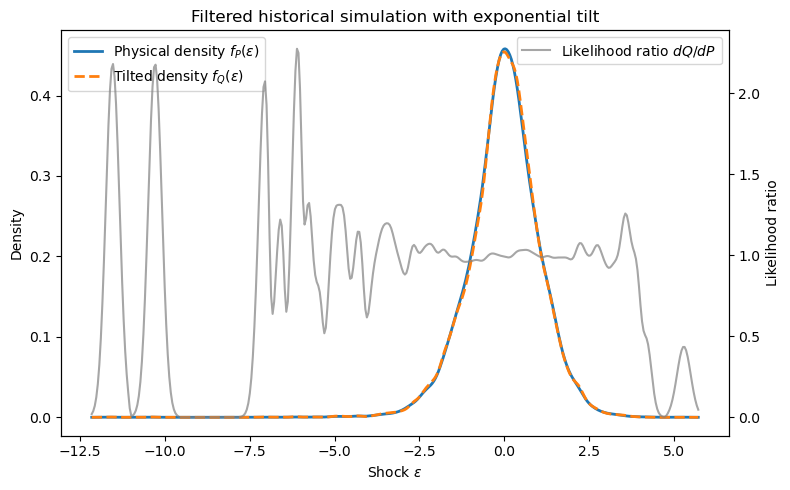

In [10]:
###### Question 4 ######
eps_array = np.asarray(eps)
lam = params['lambda']

# Exponential tilt weights q_i(η)

def compute_Q_weights(eps_array, eta):
    """
    q_i(η) ∝ exp(-η ε_i)
    Under P the weights are 1/N; under Q they are q_i(η).
    """
    w = np.exp(-eta * eps_array)
    q = w / w.sum()
    return q

#  Sample Q-shocks via historical simulation 
def sample_Q_shocks(eps_array, lam, n_samples=50_000, seed=123):

    rng = np.random.default_rng(seed)
    N = len(eps_array)
    q = compute_Q_weights(eps_array, lam)
    idx = rng.choice(N, size=n_samples, replace=True, p=q)
    eps_Q = eps_array[idx] + lam
    return eps_Q, q

eps_Q, q_weights = sample_Q_shocks(eps_array, lam)

print("Empirical mean under P  (ε):   ", eps_array.mean())
print("Empirical mean under Q (ε^Q): ", eps_Q.mean())

#  KDEs for P and Q-shocks 
xmin = min(eps_array.min(), eps_Q.min()) - 0.5
xmax = max(eps_array.max(), eps_Q.max()) + 0.5
grid = np.linspace(xmin, xmax, 400)

kde_P = gaussian_kde(eps_array)
kde_Q = gaussian_kde(eps_Q)

f_P = kde_P(grid)
f_Q = kde_Q(grid)

eps_denom = 1e-10
likelihood_ratio = f_Q / np.maximum(f_P, eps_denom)

#  Plots 
fig, ax1 = plt.subplots(figsize=(8, 5))

ax1.plot(grid, f_P, label=r"Physical density $f_P(\varepsilon)$", lw=2)
ax1.plot(grid, f_Q, label=r"Tilted density $f_Q(\varepsilon)$", lw=2, linestyle="--")
ax1.set_xlabel(r"Shock $\varepsilon$")
ax1.set_ylabel("Density")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(grid, likelihood_ratio, color="gray", alpha=0.7,
         label=r"Likelihood ratio $dQ/dP$")
ax2.set_ylabel("Likelihood ratio")
ax2.legend(loc="upper right")

plt.title("Filtered historical simulation with exponential tilt")
plt.tight_layout()
plt.show()


# Question 5

Repeat the exercise in Question 3, but using the FHS setup in Question 4 rather than $N(0,1)$ shocks. Does your VIX approximation improve? Discuss.

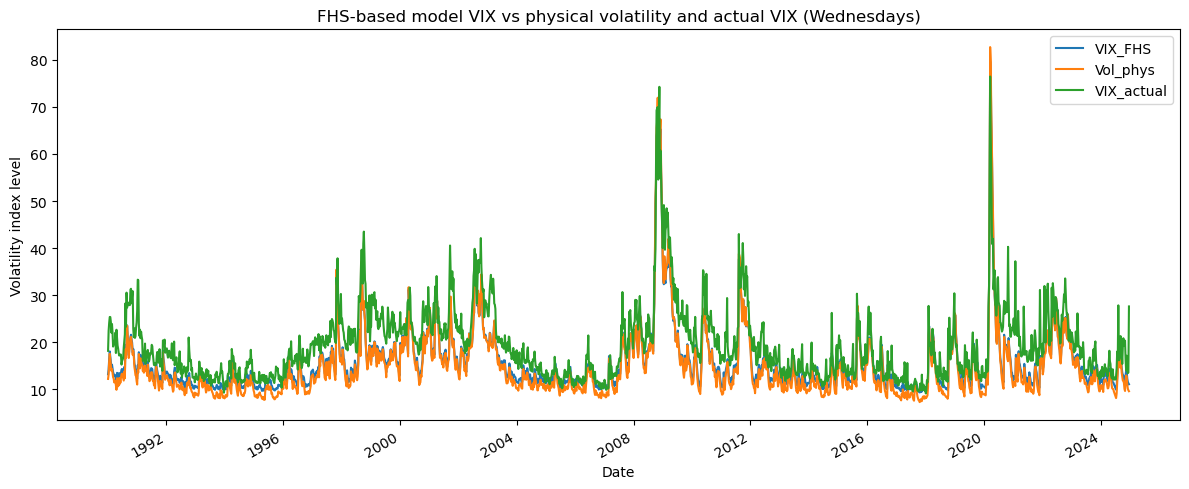

Q5 correlation matrix:
             VIX_FHS  Vol_phys  VIX_actual
VIX_FHS     1.000000  0.999467    0.893249
Vol_phys    0.999467  1.000000    0.897809
VIX_actual  0.893249  0.897809    1.000000

Q5 summary statistics:
           VIX_FHS     Vol_phys   VIX_actual
count  1805.000000  1805.000000  1805.000000
mean     15.752497    14.828427    19.443889
std       6.885678     7.472925     7.798583
min       9.361492     7.304338     9.150000
25%      11.762218    10.383944    13.790000
50%      13.680553    12.670446    17.770000
75%      17.449924    16.899353    22.690000
max      79.602857    82.701346    76.450000


In [11]:
# Prep: series
h_series = pd.Series(h, index=r.index, name="h")
duan_vol_ann = np.sqrt(252.0 * h_series) * 100.0 

eps_array = np.asarray(eps)     
lam = params['lambda']              


# Exponential-tilt weights and FHS sampling
def compute_Q_weights(eps_array, eta):
   
    w = np.exp(-eta * eps_array)
    q = w / w.sum()
    return q

q_weights = compute_Q_weights(eps_array, lam)


def draw_eps_Q(eps_array, q_weights, lam, n_paths, rng):
    
    N = len(eps_array)
    idx = rng.choice(N, size=n_paths, replace=True, p=q_weights)
    eps_Q = eps_array[idx] + lam
    return eps_Q


#  Risk-neutral NGARCH
def get_rn_params(params):

    params_Q = params.copy()
    params_Q['gamma']  = params['gamma'] + params['lambda']
    params_Q['lambda'] = 0.0
    return params_Q

params_Q = get_rn_params(params)


#  NGARCH path simulation under Q
def simulate_ngarch_paths_Q_FHS(S0, h0, rf_d, y_d,
                                params_Q, eps_array, q_weights, lam,
                                n_days=21, n_paths=20000, random_state=None):

    rng = np.random.default_rng(random_state)

    omega = params_Q['omega']
    alpha = params_Q['alpha']
    beta  = params_Q['beta']
    gammaQ = params_Q['gamma']

    S = np.full(n_paths, S0, dtype=float)
    h = np.full(n_paths, h0, dtype=float)

    for _ in range(n_days):
        eps_Q = draw_eps_Q(eps_array, q_weights, lam, n_paths, rng)

        r_excess = -0.5 * h + np.sqrt(h) * eps_Q

        log_ret = r_excess - y_d + rf_d
        S *= np.exp(log_ret)

        h = omega + alpha * h * (eps_Q - gammaQ) ** 2 + beta * h

    return S, h


# FHS-based model VIX 
vix_start = vix_close.index.min()
vix_end   = vix_close.index.max()
common_dates = r.index[(r.index >= vix_start) & (r.index <= vix_end)]

# Wednesdays only 
wed_dates = common_dates[common_dates.weekday == 2]

m_grid = build_m_grid()
n_paths = 20000       
horizon_days = 21    

vix_model_fhs = pd.Series(index=wed_dates, dtype=float)

for d in wed_dates:
    S0   = spx.loc[d, 'spindx']
    h0   = h_series.loc[d]
    rf_d = rf_daily.loc[d]
    y_d  = y_daily.loc[d]

    S_T, h_T = simulate_ngarch_paths_Q_FHS(
        S0, h0, rf_d, y_d,
        params_Q, eps_array, q_weights, lam,
        n_days=horizon_days, n_paths=n_paths
    )

    F, df, R_f, T = forward_and_discount(S0, rf_d, y_d, T_days=30)
    strikes, C, P = price_options_from_paths(S_T, F, h0, m_grid, df)

    VIX_fhs, _ = vix_from_option_curve(strikes, C, P, F, R_f, T)
    vix_model_fhs.loc[d] = VIX_fhs


#  FHS VIX vs Gaussian VIX
cols = [
    vix_model_fhs.rename("VIX_FHS"),
    duan_vol_ann.rename("Vol_phys"),
    vix_close.rename("VIX_actual"),
]

plot_df_q5 = pd.concat(cols, axis=1, join="inner").dropna()

fig, ax = plt.subplots(figsize=(12, 5))
plot_df_q5.plot(ax=ax)
ax.set_title("FHS-based model VIX vs physical volatility and actual VIX (Wednesdays)")
ax.set_ylabel("Volatility index level")
ax.set_xlabel("Date")
plt.tight_layout()
plt.show()

print("Q5 correlation matrix:")
print(plot_df_q5.corr())
print("\nQ5 summary statistics:")
print(plot_df_q5.describe())


# Bonus question

Instead of an ad-hoc non-normal NGARCH model, repeat the above analysis with the Bates (2000) model.

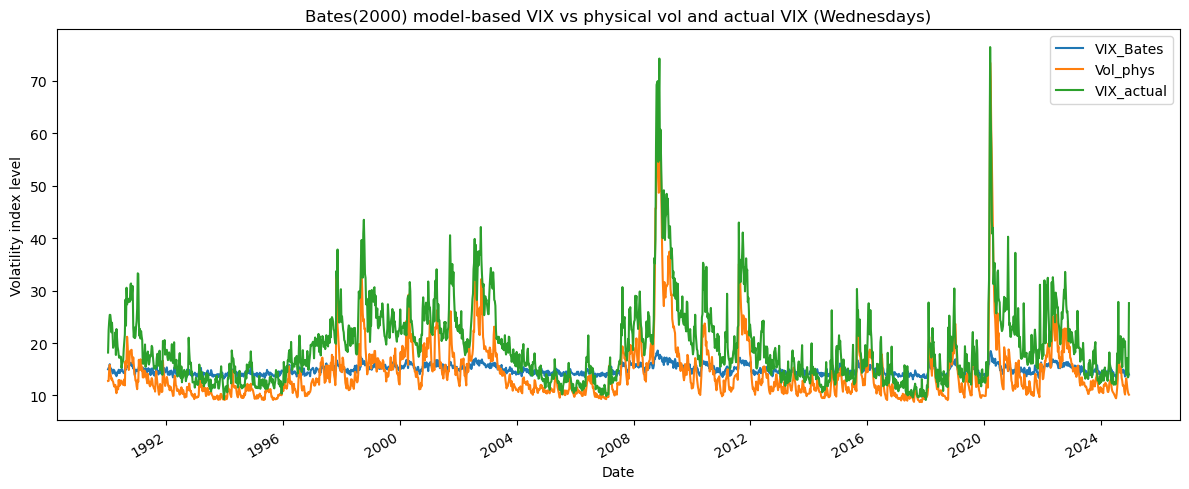

Correlation matrix (Bates vs actual VIX etc.):
            VIX_Bates  Vol_phys  VIX_actual
VIX_Bates    1.000000  0.820940    0.801995
Vol_phys     0.820940  1.000000    0.881932
VIX_actual   0.801995  0.881932    1.000000 

Summary statistics:
         VIX_Bates     Vol_phys   VIX_actual
count  1805.000000  1805.000000  1805.000000
mean     14.884140    14.329117    19.443889
std       0.854380     6.100802     7.798583
min      13.083322     8.740752     9.150000
25%      14.222945    10.857657    13.790000
50%      14.761788    12.540184    17.770000
75%      15.452607    15.825167    22.690000
max      18.570824    73.498662    76.450000


In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==========================
# 0. “Physical” vol from NGARCH (for comparison only)
# ==========================

h_series = pd.Series(h, index=r.index, name="h")
duan_vol_ann = np.sqrt(252.0 * h_series) * 100.0   # 100× daily vol → annual %


# ==========================
# 1. Helpers (same VIX machinery as Q3)
# ==========================

def build_m_grid(m_min=-5.0, m_max=5.0, n_m=41):
    """Standardized moneyness grid m ∈ [m_min, m_max]."""
    return np.linspace(m_min, m_max, n_m)


def forward_and_discount(S0, rf_d, y_d, T_days=30):
    """
    Approximate 30-calendar-day forward and discount factor
    from *daily* rf_d and dividend yield y_d (both in decimal).
    """
    R_f = rf_d * T_days           # simple 1M rate (annual ≈ rf_d*252)
    Q   = y_d  * T_days           # simple 1M dividend yield
    T   = T_days / 365.0
    F   = S0 * np.exp(R_f - Q)
    df  = np.exp(-R_f)
    return F, df, R_f, T


def vix_from_option_curve(strikes, call_prices, put_prices, F, R_f, T):
    """
    CBOE VIX formula for a single ~30-day maturity.
    """
    K = np.asarray(strikes)
    C = np.asarray(call_prices)
    P = np.asarray(put_prices)

    # Strike just below forward
    idx0 = np.argmin(np.abs(K - F))
    K0 = K[idx0]

    # OTM option “Q(K)”
    QK = np.zeros_like(K)
    for i, Ki in enumerate(K):
        if Ki < K0:
            QK[i] = P[i]             # OTM put
        elif Ki > K0:
            QK[i] = C[i]             # OTM call
        else:
            QK[i] = 0.5 * (C[i] + P[i])

    # ΔK
    deltaK = np.zeros_like(K)
    deltaK[0]  = K[1] - K[0]
    deltaK[-1] = K[-1] - K[-2]
    deltaK[1:-1] = (K[2:] - K[:-2]) / 2.0

    # Forward variance
    sigma2 = (2.0 * np.exp(R_f) / T) * np.sum(deltaK * QK / (K ** 2)) \
             - (1.0 / T) * ((F / K0 - 1.0) ** 2)

    sigma2 = max(sigma2, 0.0)  # numerical safety
    VIX = 100.0 * np.sqrt(sigma2)
    return VIX, sigma2


# ==========================
# 2. Bates(2000) dynamics under Q with fixes
# ==========================

# ► Put your (risk-neutral) Bates parameters here
batesQ_params = {
    "kappa_v":  2.0,    # mean reversion speed of variance
    "theta_v":  0.04,   # long-run variance (e.g. 20%^2)
    "sigma_v":  0.5,    # vol-of-vol
    "rho":     -0.7,    # corr(dW1, dW2)
    "lambdaJ":  0.5,    # jump intensity PER YEAR
    "muJ":     -0.1,    # mean log jump size
    "sigmaJ":   0.2     # std of log jump size
}
# You can tweak / calibrate these later.


def simulate_bates_paths_Q(S0, v0, rf_ann, y_ann, params,
                           n_days=21, n_paths=20000, random_state=None):
    """
    Simulate Bates (Heston + jumps) under Q for n_days *business* days.

    Inputs
    ------
    S0      : initial spot
    v0      : initial variance (per day; we reuse NGARCH h_t)
    rf_ann  : ANNUAL risk-free rate (decimal)
    y_ann   : ANNUAL dividend yield (decimal)
    params  : dict of Bates Q-parameters (kappa_v, theta_v, sigma_v, rho,
                                       lambdaJ, muJ, sigmaJ)
    Returns
    -------
    S_T (n_paths,), v_T (n_paths,)
    """
    rng = np.random.default_rng(random_state)

    kappa_v = params["kappa_v"]
    theta_v = params["theta_v"]
    sigma_v = params["sigma_v"]
    rho     = params["rho"]
    lambdaJ = params["lambdaJ"]   # intensity per YEAR
    muJ     = params["muJ"]
    sigmaJ  = params["sigmaJ"]

    # Jump compensator
    kappaJ     = np.exp(muJ + 0.5 * sigmaJ**2) - 1.0
    dt         = 1.0 / 252.0      # business day in years
    lambdaJ_dt = lambdaJ * dt     # Poisson parameter per step

    S = np.full(n_paths, S0, dtype=float)
    v = np.full(n_paths, v0, dtype=float)

    for _ in range(n_days):
        # Correlated Brownian increments
        z1 = rng.standard_normal(n_paths)
        z2 = rng.standard_normal(n_paths)
        dW1 = np.sqrt(dt) * z1
        dW2 = np.sqrt(dt) * (rho * z1 + np.sqrt(1 - rho**2) * z2)

        # Variance process (Heston; full truncation)
        v = np.maximum(v, 0.0)
        v_prev = v.copy()

        v = v_prev + kappa_v * (theta_v - v_prev) * dt \
                 + sigma_v * np.sqrt(np.maximum(v_prev, 0.0)) * dW2
        v = np.maximum(v, 0.0)

        # Jumps: Poisson arrivals, lognormal sizes
        nJumps = rng.poisson(lambdaJ_dt, size=n_paths)
        J = np.exp(muJ + sigmaJ * rng.standard_normal(n_paths))
        jump_factor = np.where(nJumps > 0, J, 1.0)

        # Risk-neutral drift: (r - q - λJ κJ − 0.5 v) dt
        mu_q = rf_ann - y_ann - lambdaJ * kappaJ
        dlogS = (mu_q - 0.5 * v_prev) * dt + np.sqrt(np.maximum(v_prev, 0.0)) * dW1

        S *= np.exp(dlogS) * jump_factor

    return S, v


# ==========================
# 3. Bates model-based VIX on Wednesdays
# ==========================

# 3.1 choose dates where we have both NGARCH and VIX
vix_start = vix_close.index.min()
vix_end   = vix_close.index.max()
common_dates = r.index[(r.index >= vix_start) & (r.index <= vix_end)]

# Wednesdays only (Mon=0 ... Wed=2)
wed_dates = common_dates[common_dates.weekday == 2]

m_grid       = build_m_grid()
n_paths      = 20000     # reduce if too slow
horizon_days = 21        # 21 business days ≈ 1 month

vix_model_bates = pd.Series(index=wed_dates, dtype=float)

for d in wed_dates:
    S0      = spx.loc[d, 'spindx']
    v0      = h_series.loc[d]            # treat NGARCH h_t as current variance
    rf_d    = rf_daily.loc[d]           # daily rf
    y_d     = y_daily.loc[d]            # daily dividend yield

    # convert to annual rates for the SDE drift
    rf_ann = rf_d * 252.0
    y_ann  = y_d  * 252.0

    # simulate Bates under Q
    S_T, v_T = simulate_bates_paths_Q(
        S0, v0, rf_ann, y_ann,
        batesQ_params,
        n_days=horizon_days,
        n_paths=n_paths
    )

    # Forward, discount, etc. for 30 calendar days
    F, df, R_f, T = forward_and_discount(S0, rf_d, y_d, T_days=30)

    # strikes from standardized m using *starting* variance v0
    sigma_bar = np.sqrt((252.0 / 12.0) * v0)   # √((252/12) v0)
    strikes = F * np.exp(m_grid * sigma_bar)

    # price options from terminal prices
    call_prices = []
    put_prices  = []
    for K in strikes:
        payoff_call = np.maximum(S_T - K, 0.0)
        payoff_put  = np.maximum(K - S_T, 0.0)
        call_prices.append(df * payoff_call.mean())
        put_prices.append(df * payoff_put.mean())
    call_prices = np.array(call_prices)
    put_prices  = np.array(put_prices)

    # model-based VIX from Bates option strip
    VIX_bates, _ = vix_from_option_curve(strikes, call_prices, put_prices, F, R_f, T)
    vix_model_bates.loc[d] = VIX_bates


# ==========================
# 4. Plot & statistics
# ==========================

bates_df = pd.concat(
    [
        vix_model_bates.rename("VIX_Bates"),
        duan_vol_ann.rename("Vol_phys"),
        vix_close.rename("VIX_actual"),
    ],
    axis=1,
    join="inner",
).dropna()

fig, ax = plt.subplots(figsize=(12, 5))
bates_df[["VIX_Bates", "Vol_phys", "VIX_actual"]].plot(ax=ax)
ax.set_title("Bates(2000) model-based VIX vs physical vol and actual VIX (Wednesdays)")
ax.set_ylabel("Volatility index level")
ax.set_xlabel("Date")
plt.tight_layout()
plt.show()

print("Correlation matrix (Bates vs actual VIX etc.):")
print(bates_df.corr(), "\n")

print("Summary statistics:")
print(bates_df.describe())

In [50]:
rmse_bates = np.sqrt(((bates_df["VIX_Bates"] - bates_df["VIX_actual"])**2).mean())
print(f"\nRMSE between Bates model VIX and actual VIX: {rmse_bates:.4f}")

rmse_fhs = np.sqrt(((plot_df_q5["VIX_FHS"] - plot_df_q5["VIX_actual"])**2).mean())
print(f"RMSE between FHS model VIX and actual VIX: {rmse_fhs:.4f}")

rmse_gauss = np.sqrt(((plot_df["VIX_model"] - plot_df["VIX_actual"])**2).mean())
print(f"RMSE between Gaussian model VIX and actual VIX: {rmse_gauss:.4f}")


RMSE between Bates model VIX and actual VIX: 8.4631
RMSE between FHS model VIX and actual VIX: 4.0119
RMSE between Gaussian model VIX and actual VIX: 7.0597


In [51]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# ---------- Common prep ----------
h_series = pd.Series(h, index=r.index, name="h")
duan_vol_ann = np.sqrt(252.0 * h_series) * 100.0   # physical vol proxy


# ---------- Bates(Q) parameters (initial guess) ----------
batesQ_params = {
    "kappa_v":  2.0,    # speed of mean reversion
    "theta_v":  0.04,   # long-run variance
    "sigma_v":  0.5,    # vol-of-vol
    "rho":     -0.7,    # corr between price and variance shocks
    "lambdaJ":  0.5,    # jump intensity per YEAR
    "muJ":     -0.1,    # mean log jump size
    "sigmaJ":   0.2     # std of log jump size
}


def simulate_bates_paths_Q(S0, v0, rf_ann, y_ann, params,
                           n_days=21, n_paths=20000, random_state=None):
    """
    Simulate Bates (Heston + jumps) under Q for n_days business days.
    v0 is *daily* variance (we reuse NGARCH h_t).
    rf_ann, y_ann are ANNUAL rates (decimal).
    """
    rng = np.random.default_rng(random_state)

    kappa_v = params["kappa_v"]
    theta_v = params["theta_v"]
    sigma_v = params["sigma_v"]
    rho     = params["rho"]
    lambdaJ = params["lambdaJ"]   # per year
    muJ     = params["muJ"]
    sigmaJ  = params["sigmaJ"]

    kappaJ     = np.exp(muJ + 0.5 * sigmaJ**2) - 1.0
    dt         = 1.0 / 252.0
    lambdaJ_dt = lambdaJ * dt

    S = np.full(n_paths, S0, dtype=float)
    v = np.full(n_paths, v0, dtype=float)

    for _ in range(n_days):
        # correlated Brownian increments
        z1 = rng.standard_normal(n_paths)
        z2 = rng.standard_normal(n_paths)
        dW1 = np.sqrt(dt) * z1
        dW2 = np.sqrt(dt) * (rho * z1 + np.sqrt(1 - rho**2) * z2)

        # variance dynamics (full truncation Heston)
        v = np.maximum(v, 0.0)
        v_prev = v.copy()
        v = v_prev + kappa_v * (theta_v - v_prev) * dt \
                 + sigma_v * np.sqrt(np.maximum(v_prev, 0.0)) * dW2
        v = np.maximum(v, 0.0)

        # jumps
        nJumps = rng.poisson(lambdaJ_dt, size=n_paths)
        J = np.exp(muJ + sigmaJ * rng.standard_normal(n_paths))
        jump_factor = np.where(nJumps > 0, J, 1.0)

        # risk-neutral drift for log S
        mu_q = rf_ann - y_ann - lambdaJ * kappaJ
        dlogS = (mu_q - 0.5 * v_prev) * dt + np.sqrt(np.maximum(v_prev, 0.0)) * dW1

        S *= np.exp(dlogS) * jump_factor

    return S, v


def compute_bates_vix_series(params, dates, n_paths=10000):
    """
    Compute Bates model-based VIX on given dates (typically Wednesdays).
    Uses NGARCH h_t as current variance v0 at each date.
    """
    m_grid       = build_m_grid()
    horizon_days = 21

    vix_bates = pd.Series(index=dates, dtype=float)

    for d in dates:
        S0   = spx.loc[d, 'spindx']
        v0   = h_series.loc[d]
        rf_d = rf_daily.loc[d]      # daily
        y_d  = y_daily.loc[d]

        rf_ann = rf_d * 252.0
        y_ann  = y_d  * 252.0

        # simulate under Bates Q
        S_T, v_T = simulate_bates_paths_Q(
            S0, v0, rf_ann, y_ann, params,
            n_days=horizon_days, n_paths=n_paths
        )

        # forward & discount for 30 calendar days
        F, df, R_f, T = forward_and_discount(S0, rf_d, y_d, T_days=30)

        # standardized-m strikes using starting variance v0
        sigma_bar = np.sqrt((252.0 / 12.0) * v0)
        strikes = F * np.exp(m_grid * sigma_bar)

        call_prices, put_prices = [], []
        for K in strikes:
            payoff_call = np.maximum(S_T - K, 0.0)
            payoff_put  = np.maximum(K - S_T, 0.0)
            call_prices.append(df * payoff_call.mean())
            put_prices.append(df * payoff_put.mean())

        call_prices = np.array(call_prices)
        put_prices  = np.array(put_prices)

        VIX_b, _ = vix_from_option_curve(strikes, call_prices, put_prices, F, R_f, T)
        vix_bates.loc[d] = VIX_b

    return vix_bates


In [52]:
# ---------- Calibration set: sub-sampled Wednesdays ----------
vix_start = vix_close.index.min()
vix_end   = vix_close.index.max()
common_dates = r.index[(r.index >= vix_start) & (r.index <= vix_end)]
wed_dates = common_dates[common_dates.weekday == 2]

# e.g. every 3rd Wednesday to speed things up
calib_dates = wed_dates[::3]


def bates_rmse_theta_lambda(x):
    """
    x[0] = theta_v, x[1] = lambdaJ
    returns RMSE between Bates VIX and actual VIX on calib_dates.
    """
    theta_v, lambdaJ = x
    params_local = batesQ_params.copy()
    params_local["theta_v"]  = theta_v
    params_local["lambdaJ"]  = lambdaJ

    vix_bates_calib = compute_bates_vix_series(params_local, calib_dates, n_paths=5000)
    df_calib = pd.concat(
        [vix_bates_calib.rename("VIX_Bates"),
         vix_close.loc[calib_dates].rename("VIX_actual")],
        axis=1
    ).dropna()

    rmse = np.sqrt(((df_calib["VIX_Bates"] - df_calib["VIX_actual"])**2).mean())
    return rmse


# initial guess and bounds
x0 = np.array([batesQ_params["theta_v"], batesQ_params["lambdaJ"]])
bounds = [(0.01, 0.15),   # theta_v between 10% and 39% annual vol^2
          (0.01, 1.50)]   # lambdaJ between 0.01 and 1.5 per year

res = minimize(bates_rmse_theta_lambda, x0, bounds=bounds, method="L-BFGS-B")
print("Calibration result (theta_v, lambdaJ):", res.x, "RMSE:", res.fun)

# update global Bates params with calibrated values
batesQ_params["theta_v"], batesQ_params["lambdaJ"] = res.x


Calibration result (theta_v, lambdaJ): [0.03999994 0.49999903] RMSE: 8.37652760683698


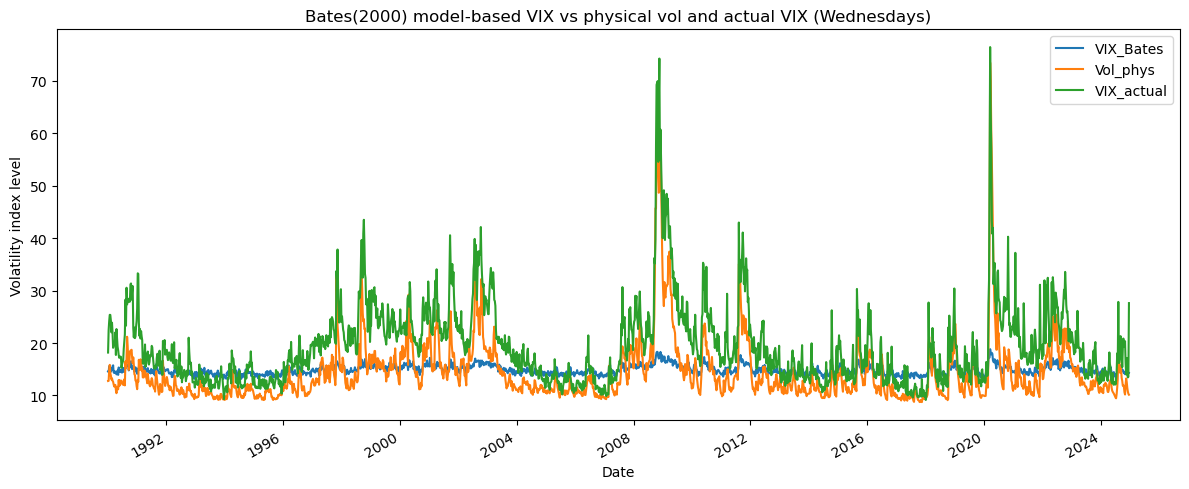

RMSE Bates vs actual VIX (full sample): 8.4671

Correlation matrix:
            VIX_Bates  Vol_phys  VIX_actual
VIX_Bates    1.000000  0.825548    0.799581
Vol_phys     0.825548  1.000000    0.881932
VIX_actual   0.799581  0.881932    1.000000

Summary stats:
         VIX_Bates     Vol_phys   VIX_actual
count  1805.000000  1805.000000  1805.000000
mean     14.870361    14.329117    19.443889
std       0.862739     6.100802     7.798583
min      13.041521     8.740752     9.150000
25%      14.245716    10.857657    13.790000
50%      14.731663    12.540184    17.770000
75%      15.400966    15.825167    22.690000
max      18.834588    73.498662    76.450000


In [53]:
# ---------- Full-sample Bates VIX using calibrated params ----------
vix_bates_full = compute_bates_vix_series(batesQ_params, wed_dates, n_paths=20000)

bates_df = pd.concat(
    [
        vix_bates_full.rename("VIX_Bates"),
        duan_vol_ann.rename("Vol_phys"),
        vix_close.rename("VIX_actual"),
    ],
    axis=1,
    join="inner",
).dropna()

# Plot
fig, ax = plt.subplots(figsize=(12, 5))
bates_df[["VIX_Bates", "Vol_phys", "VIX_actual"]].plot(ax=ax)
ax.set_title("Bates(2000) model-based VIX vs physical vol and actual VIX (Wednesdays)")
ax.set_ylabel("Volatility index level")
ax.set_xlabel("Date")
plt.tight_layout()
plt.show()

# RMSE and correlations
rmse_bates = np.sqrt(((bates_df["VIX_Bates"] - bates_df["VIX_actual"])**2).mean())
print(f"RMSE Bates vs actual VIX (full sample): {rmse_bates:.4f}\n")

print("Correlation matrix:")
print(bates_df.corr())
print("\nSummary stats:")
print(bates_df.describe())


Calibration result [theta_v, lambdaJ, muJ, sigmaJ]:
[ 0.01        0.19882393 -0.65427795  0.05      ]    RMSE on calib set: 5.805011453274163


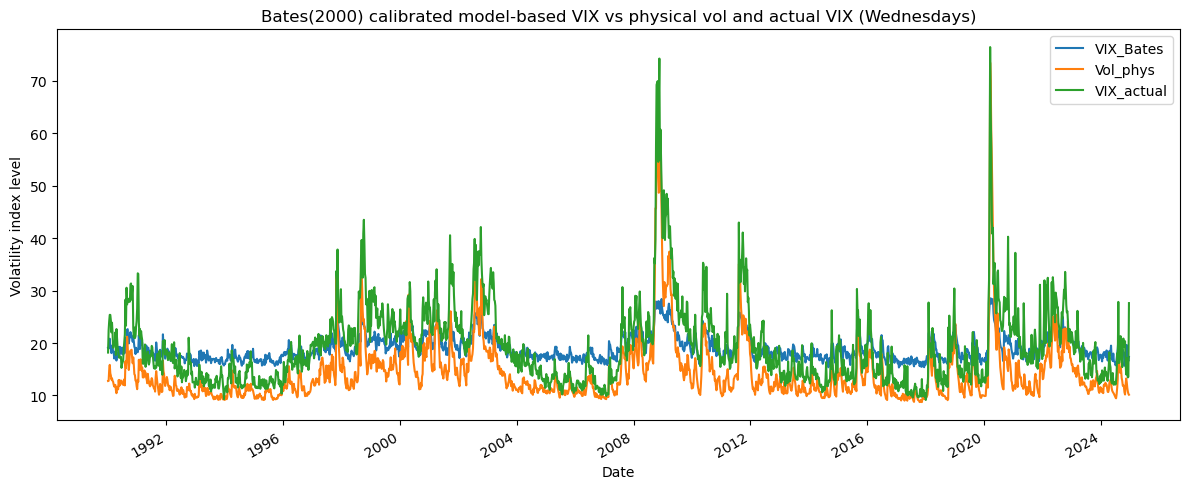


RMSE Bates vs actual VIX (full sample): 5.9458

Correlation matrix:
            VIX_Bates  Vol_phys  VIX_actual
VIX_Bates    1.000000  0.897377    0.850730
Vol_phys     0.897377  1.000000    0.881932
VIX_actual   0.850730  0.881932    1.000000 

Summary statistics:
         VIX_Bates     Vol_phys   VIX_actual
count  1805.000000  1805.000000  1805.000000
mean     19.001863    14.329117    19.443889
std       2.347929     6.100802     7.798583
min      15.244702     8.740752     9.150000
25%      17.281184    10.857657    13.790000
50%      18.398810    12.540184    17.770000
75%      20.249954    15.825167    22.690000
max      28.542650    73.498662    76.450000


In [55]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# ==========================
# 0. Prep: NGARCH-based physical vol
# ==========================
h_series = pd.Series(h, index=r.index, name="h")
duan_vol_ann = np.sqrt(252.0 * h_series) * 100.0   # 100× daily vol → annual %


# ==========================
# 1. Bates(2000) dynamics under Q
# ==========================

# Fixed “shape” parameters; we'll calibrate theta_v, lambdaJ, muJ, sigmaJ
batesQ_params = {
    "kappa_v":  2.0,    # speed of mean reversion (fixed)
    "theta_v":  0.04,   # long-run variance (to be calibrated)
    "sigma_v":  0.5,    # vol-of-vol (fixed)
    "rho":     -0.7,    # corr(dW1,dW2) (fixed)
    "lambdaJ":  0.5,    # jump intensity per YEAR (to be calibrated)
    "muJ":     -0.10,   # mean log jump (to be calibrated)
    "sigmaJ":   0.20    # std log jump (to be calibrated)
}


def simulate_bates_paths_Q(S0, v0, rf_ann, y_ann, params,
                           n_days=21, n_paths=10000, random_state=None):
    """
    Simulate Bates (Heston + jumps) under Q for n_days business days.
    v0 is daily variance; rf_ann, y_ann are ANNUAL rates (decimals).
    """
    rng = np.random.default_rng(random_state)

    kappa_v = params["kappa_v"]
    theta_v = params["theta_v"]
    sigma_v = params["sigma_v"]
    rho     = params["rho"]
    lambdaJ = params["lambdaJ"]   # per year
    muJ     = params["muJ"]
    sigmaJ  = params["sigmaJ"]

    kappaJ     = np.exp(muJ + 0.5 * sigmaJ**2) - 1.0
    dt         = 1.0 / 252.0
    lambdaJ_dt = lambdaJ * dt

    S = np.full(n_paths, S0, dtype=float)
    v = np.full(n_paths, v0, dtype=float)

    for _ in range(n_days):
        # correlated Brownian increments
        z1 = rng.standard_normal(n_paths)
        z2 = rng.standard_normal(n_paths)
        dW1 = np.sqrt(dt) * z1
        dW2 = np.sqrt(dt) * (rho * z1 + np.sqrt(1 - rho**2) * z2)

        # variance (Heston, full truncation)
        v = np.maximum(v, 0.0)
        v_prev = v.copy()
        v = v_prev + kappa_v * (theta_v - v_prev) * dt \
                 + sigma_v * np.sqrt(np.maximum(v_prev, 0.0)) * dW2
        v = np.maximum(v, 0.0)

        # jumps
        nJumps = rng.poisson(lambdaJ_dt, size=n_paths)
        J = np.exp(muJ + sigmaJ * rng.standard_normal(n_paths))
        jump_factor = np.where(nJumps > 0, J, 1.0)

        # risk-neutral log-return
        mu_q = rf_ann - y_ann - lambdaJ * kappaJ
        dlogS = (mu_q - 0.5 * v_prev) * dt + np.sqrt(np.maximum(v_prev, 0.0)) * dW1

        S *= np.exp(dlogS) * jump_factor

    return S, v


def compute_bates_vix_series(params, dates, n_paths=8000, rng_seed=1234):
    """
    Compute Bates model-based VIX on a set of dates (typically Wednesdays).
    Uses NGARCH h_t as current variance v0 at each date.
    """
    m_grid       = build_m_grid()
    horizon_days = 21
    vix_bates = pd.Series(index=dates, dtype=float)

    for i, d in enumerate(dates):
        S0   = spx.loc[d, 'spindx']
        v0   = h_series.loc[d]
        rf_d = rf_daily.loc[d]    # daily
        y_d  = y_daily.loc[d]

        rf_ann = rf_d * 252.0
        y_ann  = y_d  * 252.0

        # deterministic RNG across parameter sets: seed + index
        S_T, v_T = simulate_bates_paths_Q(
            S0, v0, rf_ann, y_ann, params,
            n_days=horizon_days,
            n_paths=n_paths,
            random_state=rng_seed + i
        )

        # 30-calendar-day forward & discount
        F, df, R_f, T = forward_and_discount(S0, rf_d, y_d, T_days=30)

        # standardized-m strikes using current variance v0
        sigma_bar = np.sqrt((252.0 / 12.0) * v0)
        strikes = F * np.exp(m_grid * sigma_bar)

        call_prices, put_prices = [], []
        for K in strikes:
            payoff_call = np.maximum(S_T - K, 0.0)
            payoff_put  = np.maximum(K - S_T, 0.0)
            call_prices.append(df * payoff_call.mean())
            put_prices.append(df * payoff_put.mean())
        call_prices = np.array(call_prices)
        put_prices  = np.array(put_prices)

        VIX_b, _ = vix_from_option_curve(strikes, call_prices, put_prices, F, R_f, T)
        vix_bates.loc[d] = VIX_b

    return vix_bates


# ==========================
# 2. Extended calibration: θ_v, λ_J, μ_J, σ_J
# ==========================

# Wednesdays within the VIX sample
vix_start = vix_close.index.min()
vix_end   = vix_close.index.max()
common_dates = r.index[(r.index >= vix_start) & (r.index <= vix_end)]
wed_dates = common_dates[common_dates.weekday == 2]

# Subsample for calibration to keep it fast
calib_dates = wed_dates[::3]   # every 3rd Wednesday


def bates_rmse_extended(x):
    """
    x = [theta_v, lambdaJ, muJ, sigmaJ]
    returns RMSE between Bates VIX and actual VIX on calib_dates.
    """
    theta_v, lambdaJ, muJ, sigmaJ = x

    params_local = batesQ_params.copy()
    params_local["theta_v"] = theta_v
    params_local["lambdaJ"] = lambdaJ
    params_local["muJ"]     = muJ
    params_local["sigmaJ"]  = sigmaJ

    vix_bates_calib = compute_bates_vix_series(params_local, calib_dates,
                                               n_paths=5000, rng_seed=999)

    df_calib = pd.concat(
        [
            vix_bates_calib.rename("VIX_Bates"),
            vix_close.loc[calib_dates].rename("VIX_actual")
        ],
        axis=1
    ).dropna()

    rmse = np.sqrt(((df_calib["VIX_Bates"] - df_calib["VIX_actual"])**2).mean())
    return rmse


# Initial guess and bounds for (theta_v, lambdaJ, muJ, sigmaJ)
x0 = np.array([
    batesQ_params["theta_v"],
    batesQ_params["lambdaJ"],
    batesQ_params["muJ"],
    batesQ_params["sigmaJ"],
])

bounds = [
    (0.01, 0.15),     # theta_v: variance between ~10% and ~39% annual vol^2
    (0.01, 1.5),      # lambdaJ: 0.01–1.5 jumps per year
    (-0.8, 0.2),      # muJ: mean log jump [-0.8, 0.2]
    (0.05, 0.8),      # sigmaJ: jump volatility
]

res = minimize(bates_rmse_extended, x0, bounds=bounds, method="L-BFGS-B")
print("Calibration result [theta_v, lambdaJ, muJ, sigmaJ]:")
print(res.x, "   RMSE on calib set:", res.fun)

# Update global Bates params with calibrated values
batesQ_params["theta_v"] = res.x[0]
batesQ_params["lambdaJ"] = res.x[1]
batesQ_params["muJ"]     = res.x[2]
batesQ_params["sigmaJ"]  = res.x[3]


# ==========================
# 3. Full-sample Bates VIX with calibrated params
# ==========================

vix_bates_full = compute_bates_vix_series(batesQ_params, wed_dates,
                                          n_paths=20000, rng_seed=2025)

bates_df = pd.concat(
    [
        vix_bates_full.rename("VIX_Bates"),
        duan_vol_ann.rename("Vol_phys"),
        vix_close.rename("VIX_actual"),
    ],
    axis=1,
    join="inner",
).dropna()

# Plot
fig, ax = plt.subplots(figsize=(12, 5))
bates_df[["VIX_Bates", "Vol_phys", "VIX_actual"]].plot(ax=ax)
ax.set_title("Bates(2000) calibrated model-based VIX vs physical vol and actual VIX (Wednesdays)")
ax.set_ylabel("Volatility index level")
ax.set_xlabel("Date")
plt.tight_layout()
plt.show()

# Diagnostics
rmse_bates = np.sqrt(((bates_df["VIX_Bates"] - bates_df["VIX_actual"])**2).mean())
print(f"\nRMSE Bates vs actual VIX (full sample): {rmse_bates:.4f}\n")

print("Correlation matrix:")
print(bates_df.corr(), "\n")

print("Summary statistics:")
print(bates_df.describe())


In [56]:
print("RMSE Bates:", rmse_bates)
print("RMSE FHS:  ", rmse_fhs)      # from your Q5 code
print("RMSE Gauss:", rmse_gauss)    # from your Q3 code


RMSE Bates: 5.945750631472968
RMSE FHS:   4.0118512847496755
RMSE Gauss: 7.059671452089805
